In [69]:
import pandas as pd
from pprint import pprint
import os
from datetime import datetime
import numpy as np
import seaborn as sns
import numpy as np
from collections import Counter, defaultdict
from tqdm import tqdm
import copy

from utils import d2_rename, d2_cols, d1_rename, d1_cols, col_ciphers, rename_ru


def get_date(x):
    try:
        return datetime.strptime(x.split(".")[0], "%Y-%m-%d %H:%M:%S")
    except (AttributeError, ValueError):
        #         print(x)
        return np.nan

## Кап ремонты

In [70]:
cols = ['work_name', "PLAN_DATE_START", 'PLAN_DATE_END', 'FACT_DATE_START', 'FACT_DATE_END']

In [71]:
d3 = pd.read_csv("data/3_capital_works.csv")
d3["PLAN_DATE_START"] = pd.to_datetime(d3["PLAN_DATE_START"], format="%d.%m.%Y")
d3["PLAN_DATE_END"] = pd.to_datetime(d3["PLAN_DATE_END"], format="%d.%m.%Y")
d3["FACT_DATE_START"] = pd.to_datetime(d3["FACT_DATE_START"], format="%d.%m.%Y")
d3["FACT_DATE_END"] = pd.to_datetime(d3["FACT_DATE_END"], format="%d.%m.%Y")
d3["start_delta"] = (d3["FACT_DATE_START"] - d3["PLAN_DATE_START"]).apply(lambda x: x.days)
d3["end_delta"] = (d3["FACT_DATE_END"] - d3["PLAN_DATE_END"]).apply(lambda x: x.days)
d3["lenght_planned"] = (d3["PLAN_DATE_END"] - d3["PLAN_DATE_START"]).apply(
    lambda x: x.days+1
)
d3["lenght_fact"] = (d3["FACT_DATE_END"] - d3["FACT_DATE_START"]).apply(
    lambda x: x.days+1
)
d3["lenght_delta"] = d3["lenght_fact"] - d3["lenght_planned"]

d3 = d3.rename(columns={'WORK_NAME': 'event', 'FACT_DATE_START': 'date_s', 'FACT_DATE_END': 'date_e', 'AdmArea':'area', 'UNOM': 'unom', 'lenght_fact':'d_len'})[['unom', 'event', 'area', 'date_s', 'date_e', 'd_len']]
d3

,unom,event,area,date_s,date_e,d_len
0,20151,замена лифтового оборудования,Восточный административный округ,2022-06-27,2022-10-14,110
1,20151,замена лифтового оборудования,Восточный административный округ,2022-09-30,2022-10-21,22
2,11466,ремонт внутридомовых инженерных систем водоотв...,Восточный административный округ,2022-02-01,2022-05-25,114
3,11466,ремонт внутридомовых инженерных систем теплосн...,Восточный административный округ,2022-05-07,2022-08-03,89
4,11466,ремонт внутридомовых инженерных систем холодно...,Восточный административный округ,2022-02-01,2022-06-27,147
...,...,...,...,...,...,...
1742,9177,ремонт внутридомовых инженерных систем теплосн...,Восточный административный округ,2022-03-07,2022-08-11,158
1743,9177,"ремонт подвальных помещений, относящихся к общ...",Восточный административный округ,2022-02-04,2022-06-17,134
1744,9177,ремонт внутридомовых инженерных систем водоотв...,Восточный административный округ,2022-02-04,2022-08-04,182
1745,12178,ремонт внутреннего водостока,Восточный административный округ,2022-10-10,2022-11-30,52


In [72]:
d4_cap = pd.read_csv('data/4_capital_types.csv').rename(columns={'Наименование':'event', 'Сокращенное наименование работы':'object'})[['event', 'object']]
d4_cap.index=d4_cap.event
d4_cap = d4_cap.drop_duplicates(keep='first')
cap_rename = dict(d4_cap['object'])
cap_rename = {k:f"{v}_c" for k, v in cap_rename.items()}
cap_rename

{'строительный контроль': 'СК_c',
 'ремонт подъездов, направленный на восстановление их надлежащего состояния и проводимый при выполнении иных работ': 'Подъезд_c',
 'ремонт подъездов, направленный на восстановление их надлежащего состояния и проводимый при выполнении иных работ по капитальному ремонту общего имущества в многоквартирном доме': 'Подъезд_c',
 'ремонт фасада (замена оконных блоков, расположенных в помещениях общего пользования в многоквартирном доме)': 'Окна_c',
 'замена оконных блоков, расположенных в помещениях общего пользования': 'Окна_c',
 'проведение экспертизы проектной документации по объектам культурного наследия федерального значения': 'проведение экспертизы_c',
 'разработка проектной документации': 'ПСД_c',
 'ремонт внутридомовых инженерных систем теплоснабжения (разводящие магистрали)': 'ЦО-М_c',
 'ремонт внутридомовых инженерных систем водоотведения (канализации) (выпуски и сборные трубопроводы)': 'КАН-М_c',
 'ремонт внутридомовых инженерных систем горячего во

In [73]:
def get_mapping_cap(x):
    try:
        return cap_rename[x]
    except KeyError:
        print(x)
        return None
d3.event = d3.event.apply(get_mapping_cap)
d3

,unom,event,area,date_s,date_e,d_len
0,20151,Лифт_c,Восточный административный округ,2022-06-27,2022-10-14,110
1,20151,Лифт_c,Восточный административный округ,2022-09-30,2022-10-21,22
2,11466,КАН-М_c,Восточный административный округ,2022-02-01,2022-05-25,114
3,11466,ЦО-М_c,Восточный административный округ,2022-05-07,2022-08-03,89
4,11466,ХВС-М_c,Восточный административный округ,2022-02-01,2022-06-27,147
...,...,...,...,...,...,...
1742,9177,ЦО-М_c,Восточный административный округ,2022-03-07,2022-08-11,158
1743,9177,Подвал_c,Восточный административный округ,2022-02-04,2022-06-17,134
1744,9177,КАН-М_c,Восточный административный округ,2022-02-04,2022-08-04,182
1745,12178,ВДСК_c,Восточный административный округ,2022-10-10,2022-11-30,52


## Читаем

In [74]:
d2_1 = pd.read_csv('data/2_1_incidents.csv')
d2_2 = pd.read_csv('data/2_2_incidents.csv')
d2 = pd.concat([d2_1, d2_2]).rename(columns=d2_rename)
d2.date_s = d2.date_s.apply(lambda x: get_date(x))
d2.date_e1 = d2.date_e1.apply(lambda x: get_date(x))
d2.date_e2 = d2.date_e2.apply(lambda x: get_date(x))
d2['date_e'] = d2.date_e1
d2.loc[d2.date_e.isna(),'date_e'] = d2[d2.date_e.isna()].date_e2
d2 = d2[d2_cols]
d2['d_len'] = (d2.date_e-d2.date_s).apply(lambda x: max(x.days, .0)+1)
d2

,unom,event,src,area,date_s,date_e,d_len
0,2115191,Открыт колодец,MVK,ВАО,2022-08-30 14:41:53,2022-08-30 15:40:26,1.0
1,2404461,Отклонение ГВС ниже нормы ночью (мониторинг),ASUPR,ВАО,2022-02-20 06:24:07,2022-04-04 02:43:22,43.0
2,2404461,Отклонение ГВС ниже нормы днем (мониторинг),ASUPR,ВАО,2022-03-07 21:04:01,2022-03-09 09:33:24,2.0
3,2404461,Температура ГВС ниже нормы,ASUPR,ВАО,2022-03-05 22:13:33,2022-03-05 19:14:00,1.0
4,2404461,Температура ГВС ниже нормы,ASUPR,ВАО,2022-02-18 21:43:54,2022-02-18 18:44:14,1.0
...,...,...,...,...,...,...,...
5301,14257,Засор канализации,EDC,ВАО,2022-10-28 08:26:59,2022-10-28 08:45:46,1.0
5302,14257,Недогрев ГВС,EDC,ВАО,2022-11-02 17:51:03,2022-11-02 19:42:59,1.0
5303,14257,Недогрев ГВС,EDC,ВАО,2022-11-03 10:19:13,2022-11-03 10:47:10,1.0
5304,14257,Недогрев ГВС,EDC,ВАО,2022-11-03 10:20:33,2022-11-03 10:47:15,1.0


In [75]:
d4_work = pd.read_csv('data/events_mapping.csv')[['event', 'object']].drop_duplicates(keep='first')
d4_work.index=d4_work.event
d4_work = d4_work.drop_duplicates(keep='first')
work_rename = dict(d4_work['object'])

def get_mapping_work(x):
    try:
        return work_rename[x]
    except KeyError:
        return None
    
d2.event = d2.event.apply(get_mapping_work)
d2

,unom,event,src,area,date_s,date_e,d_len
0,2115191,Колодец,MVK,ВАО,2022-08-30 14:41:53,2022-08-30 15:40:26,1.0
1,2404461,ГВС,ASUPR,ВАО,2022-02-20 06:24:07,2022-04-04 02:43:22,43.0
2,2404461,ГВС,ASUPR,ВАО,2022-03-07 21:04:01,2022-03-09 09:33:24,2.0
3,2404461,ГВС,ASUPR,ВАО,2022-03-05 22:13:33,2022-03-05 19:14:00,1.0
4,2404461,ГВС,ASUPR,ВАО,2022-02-18 21:43:54,2022-02-18 18:44:14,1.0
...,...,...,...,...,...,...,...
5301,14257,Канализация,EDC,ВАО,2022-10-28 08:26:59,2022-10-28 08:45:46,1.0
5302,14257,ГВС,EDC,ВАО,2022-11-02 17:51:03,2022-11-02 19:42:59,1.0
5303,14257,ГВС,EDC,ВАО,2022-11-03 10:19:13,2022-11-03 10:47:10,1.0
5304,14257,ГВС,EDC,ВАО,2022-11-03 10:20:33,2022-11-03 10:47:15,1.0


In [115]:
dict(d2[['event', 'src']].drop_duplicates(keep='first').groupby('event').agg({'src': ['last']})[('src', 'last')])

{'Авария': 'MGI',
 'Асфальт': 'MGI',
 'Внешние признаки': 'NG',
 'Вода': 'MOS_GAS',
 'ГВС': 'NG',
 'Газ': 'ASUPR',
 'Дверь': 'NG',
 'Дорога': 'MOS_GAS',
 'Животные': 'EDC',
 'Значения': 'ASUPR',
 'Канализация': 'NG',
 'Колодец': 'MOS_GAS',
 'Крыша': 'MGI',
 'Лифт': 'MGI',
 'Мусор': 'NG',
 'Мусоропровод': 'MGI',
 'Обустройство': 'MVK',
 'Окна': 'MGI',
 'Особое': 'MVK',
 'Отопление': 'MGI',
 'ПУ': 'ASUPR',
 'Перекрытие': 'NG',
 'Подтопление': 'MVK',
 'Пожар': 'NG',
 'Почта': 'NG',
 'Ремонт': 'EDC',
 'Свет': 'NG',
 'Связь': 'ASUPR',
 'Трубопровод': 'NG',
 'УСПД': 'ASUPR',
 'Электричество': 'ASUPR'}

## Дома

In [116]:
int_cols = ['year', 'floors', 'padiks', 'walls', 'break', 'elev', 'elev_semiload', 'elev_load', 'roof_queue', 'roof_material','found_type', 'status', 'manage'] 


input_data = pd.read_csv('data/1_houses.csv')
d1_f = d1.copy(deep=True).rename(columns=d1_rename)[d1_cols]for col in int_cols:
    d1_f[col] = d1_f[col].astype(pd.Int64Dtype())
    
d1_f = d1_f.replace(np.nan, pd.NA)


en_col_ciphers = dict()
for c in col_ciphers:
    try:
        en_col_ciphers[d1_rename[c]] = col_ciphers[c]
        en_col_ciphers[d1_rename[c]][pd.NA] = pd.NA
    except KeyError:
        continue
for col in en_col_ciphers:
    if col in d1_f.columns:
        print(col)
        d1_f[col] = d1_f[col].apply(lambda x: en_col_ciphers[col][x])
d1_f.head()

/tmp/ipykernel_245897/1643978099.py:1: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  input_data = pd.read_csv('data/1_houses.csv')


,unom,year,floors,padiks,apts,S,S_l,S_u,wear,walls,break,elev,elev_semiload,elev_load,roof_queue,roof_material,found_type,status,manage
0,49928,1956.0,1.0,2.0,1.0,76.0,76.0,0.0,NaN,179625102.0,22728486.0,0.0,0.0,0.0,NaN,22289204.0,22741963.0,58761330,NaN
1,64148,2005.0,18.0,2.0,148.0,8266.0,8220.0,46.0,NaN,179625111.0,22728486.0,2.0,2.0,0.0,NaN,22289201.0,42875644.0,58761330,45063584.0
2,19485,1955.0,4.0,2.0,20.0,1240.0,1070.0,170.0,NaN,179625102.0,22728486.0,0.0,0.0,0.0,22289162.0,22289204.0,42875644.0,58761330,45063584.0
3,18533,1960.0,5.0,3.0,60.0,2518.0,2492.0,26.0,NaN,179625102.0,22728486.0,0.0,0.0,0.0,22289162.0,22289201.0,42875644.0,58761330,45063584.0
4,22830,1973.0,9.0,12.0,431.0,21103.0,21088.0,15.0,0.0,2048929.0,22728486.0,12.0,0.0,0.0,NaN,22289201.0,42875644.0,58761330,45063584.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18427,6003997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42875644.0,58761330,45063584.0
18428,5259334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42875644.0,58761330,45063584.0
18429,5259335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42875644.0,58761330,45063584.0
18430,5259332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42875644.0,58761330,45063584.0


In [119]:
en_col_ciphers

{'walls': {2048928: 'кирпичный',
  2048929: 'панельные',
  2048930: 'блочные',
  2048931: 'деревянные',
  2048932: 'Смешанные',
  2048933: 'шлакобетонные и шлакоблочные из тепл.бетона и шлакозалив.',
  2048934: 'прочие (каркасно-засыпные)',
  2048935: 'металлические',
  2048936: 'монолитный железобетон',
  2048937: 'железобетонный каркас с зеркальным остеклением',
  2048938: 'панели алюминиевые трехслойные типа "ПТАР"',
  2048939: 'витражи в алюминиевом переплете',
  2048940: 'не установлен',
  2048941: 'панели типа "Сэндвич"',
  2048942: 'пеноблоки',
  2048943: 'монолитно-кирпичные',
  2048944: 'каркас монолит-ж/б с заполнением пенобет.блоками с утеплител',
  2048945: 'не определено',
  101812166: 'Каменные, кирпичные',
  101812167: 'Монолитные',
  101812168: 'иное',
  179624987: 'архив стэкс',
  179625080: 'бетонные',
  179625081: 'гипсобетонные',
  179625082: 'гипсокартонные',
  179625083: 'гипсолитовые',
  179625084: 'деревянные брусовые',
  179625085: 'деревянные неоштукатуренные'

walls
manage
status
break
roof_queue
roof_material
found_type


,unom,year,floors,padiks,apts,S,S_l,S_u,wear,walls,break,elev,elev_semiload,elev_load,roof_queue,roof_material,found_type,status,manage
0,49928,1956.0,1.0,2.0,1.0,76.0,76.0,0.0,<NA>,кирпичные,нет,0.0,0.0,0.0,<NA>,стальная,частный фонд,в эксплуатации,<NA>
1,64148,2005.0,18.0,2.0,148.0,8266.0,8220.0,46.0,<NA>,монолитные (ж-б),нет,2.0,2.0,0.0,<NA>,мягкая-совмещенная с рубероидным покрытием,МКД,в эксплуатации,УО
2,19485,1955.0,4.0,2.0,20.0,1240.0,1070.0,170.0,<NA>,кирпичные,нет,0.0,0.0,0.0,1 очередь,стальная,МКД,в эксплуатации,УО
3,18533,1960.0,5.0,3.0,60.0,2518.0,2492.0,26.0,<NA>,кирпичные,нет,0.0,0.0,0.0,1 очередь,мягкая-совмещенная с рубероидным покрытием,МКД,в эксплуатации,УО
4,22830,1973.0,9.0,12.0,431.0,21103.0,21088.0,15.0,0.0,панельные,нет,12.0,0.0,0.0,<NA>,мягкая-совмещенная с рубероидным покрытием,МКД,в эксплуатации,УО


In [76]:
d1 = pd.read_csv('data/1_houses.csv')
d1_full_name = pd.read_csv('data/1_houses_full_header.csv')
id2col = dict(d1_full_name.iloc[:1, 4:].T[0])
for key in id2col:
    if id2col[key] in d1_rename:
        id2col[key] = d1_rename[id2col[key]]
col2id = {v: k for k, v in id2col.items()}
print('id to collections')
pprint(id2col)
print('collectios to id')
pprint(col2id)
d1_f = d1[d1.UNOM.isin(list(d2.unom))].copy(deep=True).rename(columns=d1_rename)[d1_cols]
d1_f

/tmp/ipykernel_245897/2604134369.py:1: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  d1 = pd.read_csv('data/1_houses.csv')
/tmp/ipykernel_245897/2604134369.py:2: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  d1_full_name = pd.read_csv('data/1_houses_full_header.csv')


id to collections
{'COL_103506': 'Категория МКД',
 'COL_2156': 'Вид социального объекта',
 'COL_2463': 'found_type',
 'COL_3163': 'status',
 'COL_3243': 'manage',
 'COL_3363': 'elev_load',
 'COL_3468': 'Причина Изменения Статуса МКД',
 'COL_754': 'Назначение',
 'COL_755': 'Форма собственности',
 'COL_756': 'year',
 'COL_757': 'Год реконструкции',
 'COL_758': 'Серия проекта',
 'COL_759': 'floors',
 'COL_760': 'padiks',
 'COL_761': 'apts',
 'COL_762': 'S',
 'COL_763': 'S_l',
 'COL_764': 'S_u',
 'COL_765': 'Строительный объем',
 'COL_766': 'wear',
 'COL_767': 'Класс энергоэффективности',
 'COL_769': 'walls',
 'COL_770': 'break',
 'COL_771': 'elev',
 'COL_772': 'elev_semiload',
 'COL_775': 'roof_queue',
 'COL_781': 'roof_material',
 'COL_782': 'unom'}
collectios to id
{'S': 'COL_762',
 'S_l': 'COL_763',
 'S_u': 'COL_764',
 'apts': 'COL_761',
 'break': 'COL_770',
 'elev': 'COL_771',
 'elev_load': 'COL_3363',
 'elev_semiload': 'COL_772',
 'floors': 'COL_759',
 'found_type': 'COL_2463',
 'man

,unom,year,floors,padiks,apts,S,S_l,S_u,wear,walls,break,elev,elev_semiload,elev_load,roof_queue,roof_material,found_type,status,manage
1,64148,2005.0,18.0,2.0,148.0,8266.0,8220.0,46.0,NaN,179625111.0,22728486.0,2.0,2.0,0.0,NaN,22289201.0,42875644.0,58761330,45063584.0
2,19485,1955.0,4.0,2.0,20.0,1240.0,1070.0,170.0,NaN,179625102.0,22728486.0,0.0,0.0,0.0,22289162.0,22289204.0,42875644.0,58761330,45063584.0
3,18533,1960.0,5.0,3.0,60.0,2518.0,2492.0,26.0,NaN,179625102.0,22728486.0,0.0,0.0,0.0,22289162.0,22289201.0,42875644.0,58761330,45063584.0
4,22830,1973.0,9.0,12.0,431.0,21103.0,21088.0,15.0,0.0,2048929.0,22728486.0,12.0,0.0,0.0,NaN,22289201.0,42875644.0,58761330,45063584.0
5,12331,1968.0,5.0,4.0,64.0,4133.0,2697.0,1436.0,NaN,179625102.0,22728486.0,0.0,0.0,0.0,22289163.0,22289201.0,42875644.0,58761330,45063584.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18383,5283529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42875644.0,58761330,45063584.0
18384,5245216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42875644.0,58761330,45063584.0
18390,5289239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42875644.0,58761330,45063584.0
18393,5249125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42875644.0,58761330,45063584.0


In [77]:
int_cols = ['year', 'floors', 'padiks', 'walls', 'break', 'elev', 'elev_semiload', 'elev_load', 'roof_queue', 'roof_material','found_type', 'status', 'manage'] 
for col in int_cols:
    d1_f[col] = d1_f[col].astype(pd.Int64Dtype())
d1_f

,unom,year,floors,padiks,apts,S,S_l,S_u,wear,walls,break,elev,elev_semiload,elev_load,roof_queue,roof_material,found_type,status,manage
1,64148,2005,18,2,148.0,8266.0,8220.0,46.0,NaN,179625111,22728486,2,2,0,<NA>,22289201,42875644,58761330,45063584
2,19485,1955,4,2,20.0,1240.0,1070.0,170.0,NaN,179625102,22728486,0,0,0,22289162,22289204,42875644,58761330,45063584
3,18533,1960,5,3,60.0,2518.0,2492.0,26.0,NaN,179625102,22728486,0,0,0,22289162,22289201,42875644,58761330,45063584
4,22830,1973,9,12,431.0,21103.0,21088.0,15.0,0.0,2048929,22728486,12,0,0,<NA>,22289201,42875644,58761330,45063584
5,12331,1968,5,4,64.0,4133.0,2697.0,1436.0,NaN,179625102,22728486,0,0,0,22289163,22289201,42875644,58761330,45063584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18383,5283529,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,42875644,58761330,45063584
18384,5245216,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,42875644,58761330,45063584
18390,5289239,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,42875644,58761330,45063584
18393,5249125,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,42875644,58761330,45063584


# Распределение продолжительности

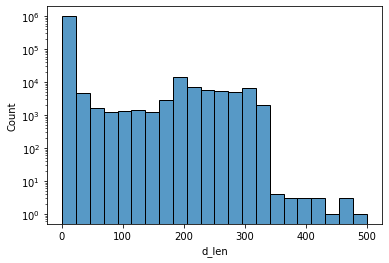

In [78]:
ax=sns.histplot(d2.d_len)
ax.set_yscale('log')

## По службам распределение

In [79]:
d2_src = d2.groupby('src').agg({'d_len': ['mean', 'max']})
d2_src

d_len       
               mean    max
src                       
ASUPR      2.448424  500.0
CAFAP     10.132343  434.0
EDC       20.960105  335.0
GORMOST    1.000000    1.0
MGI        9.259767  328.0
MOS_GAS   91.481467  366.0
MVK      105.652464  330.0
NG        20.002757  328.0

In [80]:
d2.groupby('event').agg({'d_len': ['mean', 'max']})

d_len       
                        mean    max
event                              
Авария             44.635939  335.0
Асфальт           125.272989  325.0
Внешние признаки    4.631310  162.0
Вода               22.496135  328.0
ГВС                 2.711562  500.0
Газ                75.012809  339.0
Дверь               3.907296  326.0
Дорога              3.666667    7.0
Животные          130.880464  327.0
Значения            1.651361  283.0
Канализация         4.342123  324.0
Колодец           116.556773  366.0
Крыша              22.649979  434.0
Лифт               80.562149  334.0
Мусор              10.561925  222.0
Мусоропровод        1.307499  237.0
Обустройство      113.255319  259.0
Окна                1.930491  204.0
Особое             19.970305  425.0
Отопление          14.167862  474.0
ПУ                  1.762411  253.0
Перекрытие         38.928186  328.0
Подтопление       107.011952  323.0
Пожар              66.973729  331.0
Почта               1.323248   55.0
Ремонт              1.663280    6.0
Свет                1.084416  235.0
Связь               7.141800  420.0
Трубопровод        42.994590  325.0
УСПД                1.597864  395.0
Электричество      31.015597  332.0

In [81]:
d2_agg = pd.DataFrame(d2.groupby(['unom', 'event']).agg({'d_len': ['mean', 'max', 'size']}))
d2_agg.columns = ['mean_days', 'max_days', 'len_days']
d2_agg

mean_days  max_days  len_days
unom    event                                           
308     Внешние признаки    6.833333      36.0         6
        Газ                 1.000000       1.0         3
        Дверь               1.200000       2.0         5
        Канализация         1.000000       1.0         1
        Крыша               1.000000       1.0         4
...                              ...       ...       ...
5283529 Мусор              61.500000     180.0         4
        Пожар             192.000000     192.0         1
5286357 Авария              1.000000       1.0         2
5288995 Мусор             190.000000     190.0         1
5289239 Пожар               1.000000       1.0         1

[78582 rows x 3 columns]

In [82]:
# ax=sns.histplot(d2_agg.mean_days)
# ax.set_yscale('log')

In [83]:
# ax=sns.histplot(d2_agg.max_days)
# ax.set_yscale('log')

In [84]:
# ax=sns.histplot(d2_agg.len_days)
# ax.set_yscale('log')

## Соединить здания и инциденты -- как ээто будет в странице 2

In [85]:
dm = pd.merge(d1_f, d2, left_index=True, right_on='unom')
dm = dm[['event', 'date_s', 'd_len', 'src', 'year', 'break', 'roof_material', 'walls', "found_type", "status", "manage"]]
dm.head()

,event,date_s,d_len,src,year,break,roof_material,walls,found_type,status,manage
816304,Канализация,2022-03-16 14:22:49,1.0,EDC,1965,22728486,22289201,2048929,42875644,58761330,45063584
816457,Крыша,2022-02-01 11:04:57,1.0,EDC,1965,22728486,22289201,2048929,42875644,58761330,45063584
816468,Окна,2022-06-10 17:42:38,1.0,MGI,1965,22728486,22289201,2048929,42875644,58761330,45063584
816478,Электричество,2022-06-10 17:42:44,301.0,MGI,1965,22728486,22289201,2048929,42875644,58761330,45063584
816479,Газ,2022-04-28 12:10:02,1.0,MOS_GAS,1965,22728486,22289201,2048929,42875644,58761330,45063584


In [86]:
en_col_ciphers = dict()
for c in col_ciphers:
    try:
        en_col_ciphers[d1_rename[c]] = col_ciphers[c]
        en_col_ciphers[d1_rename[c]][pd.NA] = pd.NA
    except KeyError:
        continue
for col in en_col_ciphers:
    if col in dm.columns:
        dm[col] = dm[col].apply(lambda x: en_col_ciphers[col][x])
dm.head()

,event,date_s,d_len,src,year,break,roof_material,walls,found_type,status,manage
816304,Канализация,2022-03-16 14:22:49,1.0,EDC,1965,нет,мягкая-совмещенная с рубероидным покрытием,панельные,МКД,в эксплуатации,УО
816457,Крыша,2022-02-01 11:04:57,1.0,EDC,1965,нет,мягкая-совмещенная с рубероидным покрытием,панельные,МКД,в эксплуатации,УО
816468,Окна,2022-06-10 17:42:38,1.0,MGI,1965,нет,мягкая-совмещенная с рубероидным покрытием,панельные,МКД,в эксплуатации,УО
816478,Электричество,2022-06-10 17:42:44,301.0,MGI,1965,нет,мягкая-совмещенная с рубероидным покрытием,панельные,МКД,в эксплуатации,УО
816479,Газ,2022-04-28 12:10:02,1.0,MOS_GAS,1965,нет,мягкая-совмещенная с рубероидным покрытием,панельные,МКД,в эксплуатации,УО


## Make dict dataset

In [87]:
full_stories = dict()

for key, value in d1_f.iterrows():
    unom=value.unom
    full_stories[unom] = dict()
    for c in d1_cols:
        if c in en_col_ciphers:
            full_stories[unom][c] = en_col_ciphers[c][value[c]]
        else:
            full_stories[unom][c] = value[c]
    full_stories[unom]['incidents'] = []
    full_stories[unom]['capital'] = []
full_stories

{64148: {'unom': 64148,
  'year': 2005,
  'floors': 18,
  'padiks': 2,
  'apts': 148.0,
  'S': 8266.0,
  'S_l': 8220.0,
  'S_u': 46.0,
  'wear': nan,
  'walls': 'монолитные (ж-б)',
  'break': 'нет',
  'elev': 2,
  'elev_semiload': 2,
  'elev_load': 0,
  'roof_queue': <NA>,
  'roof_material': 'мягкая-совмещенная с рубероидным покрытием',
  'found_type': 'МКД',
  'status': 'в эксплуатации',
  'manage': 'УО',
  'incidents': [],
  'capital': []},
 19485: {'unom': 19485,
  'year': 1955,
  'floors': 4,
  'padiks': 2,
  'apts': 20.0,
  'S': 1240.0,
  'S_l': 1070.0,
  'S_u': 170.0,
  'wear': nan,
  'walls': 'кирпичные',
  'break': 'нет',
  'elev': 0,
  'elev_semiload': 0,
  'elev_load': 0,
  'roof_queue': '1 очередь',
  'roof_material': 'стальная',
  'found_type': 'МКД',
  'status': 'в эксплуатации',
  'manage': 'УО',
  'incidents': [],
  'capital': []},
 18533: {'unom': 18533,
  'year': 1960,
  'floors': 5,
  'padiks': 3,
  'apts': 60.0,
  'S': 2518.0,
  'S_l': 2492.0,
  'S_u': 26.0,
  'wear'

In [88]:
not_stated = 0
for key, value in tqdm(d2.iterrows(), total=d2.shape[0]):
    incident = dict(value[1:])
    unom=value.unom
    if unom in full_stories:
        full_stories[unom]['incidents'].append(incident)
    else:
        not_stated+=1
print(not_stated)
# full_stories

100%|███████████████████████████████████████████████████████████████████████| 1053881/1053881 [01:41<00:00, 10396.47it/s]

868


In [89]:
not_stated = 0
for key, value in tqdm(d3.iterrows(), total=d3.shape[0]):
    incident = dict(value[1:])
    unom=value.unom
    if unom in full_stories:
        print(unom)
        full_stories[unom]['capital'].append(incident)
    else:
        not_stated+=1
print(not_stated)
# full_stories

 35%|███████████████████████████▊                                                   | 614/1747 [00:00<00:00, 6134.51it/s]

20151
20151
11466
11466
11466
11466
11466
2328
8576
24608
8403
22291
11723
11723
11723
11723
11723
7376
7376
7376
7376
28391
28391
28391
28391
28391
28391
11723
11723
7376
7376
7376
28391
28391
28391
22830
22830
22830
22830
22830
22830
22830
22830
22830
365
365
365
365
365
365
365
365
365
365
365
365
365
11079
11079
11079
11079
11079
11079
11079
11079
11079
11079
5945
8416
8416
8416
8416
12175
20914
21908
21910
10015
10015
10015
10012
11118
14953
14953
14953
14953
14953
14953
14953
19179
19179
19179
19179
19179
19179
19179
8652
18157
8652
18518
18518
18518
18518
18518
18518
18518
8464
8464
18531
18531
18531
4087
19188
15118
24749
24749
24749
24749
24749
24749
24749
24749
18892
18904
18904
15116
15116
15116
15116
24172
24172
24172
24172
24172
24172
19991
19991
5920
5920
26823
26823
26823
26823
26823
26823
80036
80036
80036
80036
80036
80036
80036
80036
82006
82006
82006
4091
82008
82008
82008
82008
82008
82008
82013
82013
82013
82013
82013
82013
82028
82028
82028
82028
82028
82028
82028

100%|██████████████████████████████████████████████████████████████████████████████| 1747/1747 [00:00<00:00, 7996.31it/s]

17489
21924
21924
21924
21924
21924
21924
21924
21924
29212
29212
29212
29212
29212
29212
29212
29212
29212
6311
6311
6311
6311
29212
29212
4094
18801
18801
18801
18801
18801
18801
28691
26890
26890
26890
26890
26890
26890
8891
8891
8891
8891
8891
8891
8891
8678
8678
8678
8678
8678
8678
8678
80040
80040
26898
26898
26898
26898
26898
8682
8682
22827
22827
22827
27716
27716
27716
27716
27716
27716
27716
27716
80042
80042
80042
80042
80042
80042
80042
80042
80042
80042
7377
7377
7377
7377
7377
7377
7377
18703
18703
18703
18703
18703
18675
18675
18675
18675
18675
18675
28395
28395
24239
24239
24239
24239
24239
24239
24239
24239
24239
24239
24239
24239
24239
24239
24239
28405
28405
28405
28405
28405
28405
28405
28405
29965
29965
29965
24763
24763
24763
24763
24763
24763
24763
28408
28408
28408
28408
28408
28408
28408
28409
28409
28409
28409
28409
28409
28409
20733
20733
20733
370
11724
11724
11724
14217
14217
14217
11089
11089
11089
24169
24169
24169
24169
24169
24169
462
462
462
462
19182


In [90]:
incidents_cols = set()
capital_cols = set()

column_names = [incidents_cols, capital_cols]
names = ['incidents', 'capital']

for key in tqdm(full_stories, total = len(full_stories)):
    for i, type_work in enumerate(names):
        if len(full_stories[key][type_work]) == 0:
            continue
            
        dates = pd.DataFrame(full_stories[key][type_work]).sort_values(by='date_s')
        between_dict = dict()
        for cur_event in dates.event.unique():
            days_between = pd.NA
            if len(dates)>1:
                days_between = (dates['date_s'][1:].reset_index()-dates['date_s'][:-1].reset_index()).date_s.apply(lambda x: x.days).max()
            between_dict[f'{cur_event}_between'] = days_between
            
        sub_data = pd.DataFrame(full_stories[key][type_work]).groupby('event').agg({'d_len': ['mean'], 'date_e': ['max']})
        sub_data.columns = ['length', 'last_date']
        length_dict = {f"{k}_length": v for k, v in dict(sub_data.length).items()}
        date_dict = {f"{k}_date": v for k, v in dict(sub_data.last_date).items()}
        column_names[i] = column_names[i] |  set(length_dict.keys())
        for k in length_dict:
            full_stories[key][k] = length_dict[k]
        for k in date_dict:
            full_stories[key][k] = date_dict[k]
        for k in between_dict:
            full_stories[key][k] = between_dict[k]

100%|████████████████████████████████████████████████████████████████████████████████| 6681/6681 [02:08<00:00, 51.79it/s]


In [91]:
final_dict = dict()

for key in tqdm(full_stories, total = len(full_stories)):
    check_a = copy.deepcopy(full_stories[key])
    del check_a['incidents']
    del check_a['capital']
    final_dict[key] = check_a
final_data = pd.DataFrame(final_dict).T

100%|███████████████████████████████████████████████████████████████████████████████| 6681/6681 [00:13<00:00, 484.53it/s]


In [92]:
final_cont_features = [
 'year',
 'floors',
 'padiks',
 'apts',
 'S',
 'S_l',
 'S_u',
 'elev',
 'elev_semiload',
 'elev_load',]
final_cat_features = [
 'wear',
 'walls',
 'break',
 'roof_queue',
 'roof_material',
 'found_type',
 'status',
 'manage']
final_features = final_cont_features+final_cat_features

In [93]:
flag = final_data[final_features].isna().sum(axis=1)/len(final_features)>0.5
final_data = final_data[~flag]
final_data

,unom,year,floors,padiks,apts,S,S_l,S_u,wear,walls,...,ВДСК_c_between,Дорога_length,Дорога_date,Дорога_between,КАН_c_length,КАН_c_date,КАН_c_between,ГАЗ_c_length,ГАЗ_c_date,ГАЗ_c_between
64148,64148,2005,18,2,148.0,8266.0,8220.0,46.0,NaN,монолитные (ж-б),...,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN
19485,19485,1955,4,2,20.0,1240.0,1070.0,170.0,NaN,кирпичные,...,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN
18533,18533,1960,5,3,60.0,2518.0,2492.0,26.0,NaN,кирпичные,...,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN
22830,22830,1973,9,12,431.0,21103.0,21088.0,15.0,0.0,панельные,...,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN
12331,12331,1968,5,4,64.0,4133.0,2697.0,1436.0,NaN,кирпичные,...,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5012070,5012070,2017,20,<NA>,NaN,42316.0,24468.0,17848.0,NaN,бетонные,...,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN
5012968,5012968,2017,18,<NA>,NaN,20306.0,19068.0,1238.0,NaN,монолитные (ж-б),...,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN
5024600,5024600,2018,20,<NA>,NaN,13820.0,12375.0,1445.0,NaN,монолитные (ж-б),...,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN
5034532,5034532,2017,16,<NA>,NaN,74625.0,46350.0,28275.0,NaN,монолитные (ж-б),...,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN


In [94]:
final_data.to_csv('data/to_train.csv', index = False)

In [95]:
incident_features = [i.replace('length', 'between') for i in column_names[0]]
capital_features = [i.replace('length', 'between') for i in column_names[1]]

In [96]:
capital_features

['ХВС_c_between',
 'ВДСК_c_between',
 'Подъезд_c_between',
 'ГВС_c_between',
 'Мусоропровод_c_between',
 'КАН-М_c_between',
 'ГАЗ_c_between',
 'ЭС_c_between',
 'Крыша_c_between',
 'ГВС-М_c_between',
 'КАН_c_between',
 'Фасад_c_between',
 'Подвал_c_between',
 'ПВ_c_between',
 'Лифт_c_between',
 'ЦО_c_between',
 'ЦО-М_c_between',
 'Окна_c_between',
 'ХВС-М_c_between']